## Implementing the scaling code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as intg
import corner
from scalingOIII import *

## Functions needed to analyze the MCMC chains

In [2]:
def plot_contour(samples):
    """Plot the corner
    plots of the posteriors."""
    
    labels = [r"A",r"$\sigma$",r"$\Delta \lambda$[$\AA$]"]
    a1 = samples[:,0]
    a2 = samples[:,1]
    a3 = samples[:,2]
    data = np.array([a1,a2,a3]).T
    ndim = samples[0,:].size
    
    #title = lab,quantiles=[0.05, 0.5, 0.95], label_kwargs={"fontsize": 20}, show_titles=True,title_kwargs={"fontsize": 16},)
    fig = corner.corner(data, 
                        labels = labels, 
                        fontsize = 12, 
                        show_titles = True, 
                        label_kwargs={"fontsize": 20},
                        title_kwargs = {"fontsize": 16},
                        levels=(0.683,0.90,0.99));
    
    axes = np.array(fig.axes).reshape((ndim, ndim))
    for i in range(ndim):
        ax = axes[i, i]
        ax.axvline( np.median(samples[:,i]), color="g")

    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(np.median(samples[:,xi]), color="g")
            ax.axhline(np.median(samples[:,yi]), color="g")
            ax.plot(np.median(samples[:,xi]), np.median(samples[:,yi]), "sg")
    return


def best_values(fs):
    """calculate the best-value (median) 
    of the parameters: 
    flux scaling factor, 
    spectral smoothing w.r.t the reference, 
    wavelength shift factor"""
    a0 = []
    for i in range(fs[0,:].size):
        a0.append( np.median( fs[:,i]) )
    return np.array(a0)

## Initialize the fit:
    1) Load the reference and target.
    2) Define the spectral segments.
    3) Plot the line regions: Here the scaled target spectrum is without the gaussian smoothing

Text(0, 0.5, 'Flux [erg s$^{-1}$ cm$^{-2}$ $\\AA^{-1}$]')

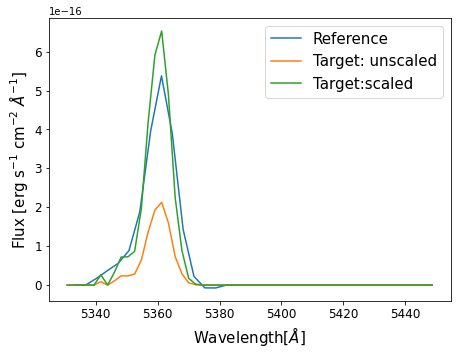

In [10]:
S1 = scale( 'ref_keck_sm2','spec_with_error/2_dct' )
S1.spectral_segments()

plt.figure( figsize=(7.2,5.2))
plt.plot( S1.xT   , S1.fl    , label="Reference")
plt.plot( S1.xOIII, S1.fline , label="Target: unscaled")
plt.plot( S1.xOIII, S1.fline*3.07 , label="Target:scaled")
#plt.plot( l, ff, label="Target: scaled")
plt.legend( loc="best", fontsize=15 )
plt.xticks( fontsize=12 )
plt.yticks( fontsize=12 )
plt.xlabel("Wavelength[$\AA$]", fontsize=15)
plt.ylabel("Flux [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]", fontsize=15)

## Run the scaling Algorithm
    a) the code corrects for the [OIII] flux value
    b) determines the amount of shift that is required to align the line centers

In [4]:
samples = S1.run_emcee( S1.xOIII, S1.fline, S1.eOIII, 5000)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:47<00:00, 22.00it/s]


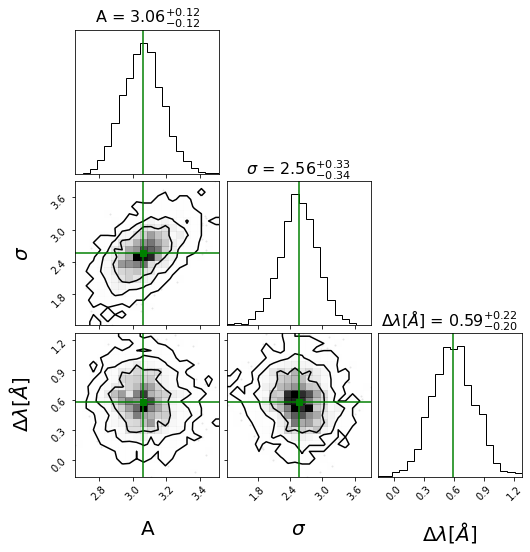

In [5]:
plot_contour(samples)
np.savetxt("chains1", samples)

In [7]:
par = best_values(samples)
l,ff,ee = S1.transform_spectrum(S1.xT, par[0], par[1], par[2])
f_transformed = intg.simps(ff,l)
f_original    = intg.simps(S1.fline, S1.xOIII)
print("Target_transformed/Reference = ",f_transformed/S1.R0)
print("Target_original/Reference = ",f_original*par[0]/S1.R0)

Target_transformed/Reference =  0.9940610075580757
Target_original/Reference =  0.9971514441656258
